<h4><b>Introduction:</b></h4>

<h5>In this notebook we forecast GOOGL stock prices using a Recurrent Neural Network (RNN).</h5>

<h4><b>About the dataset:</b></h4>

<h5>
    The dataset used in this project comes from the UCI Machine Learning Repository. This data was collected in 1978 and each of the 506 entries represents aggregate information about 14 features of homes from various suburbs located in Boston.
    <br/>The features can be summarized as follows:<br/>
    <ul>
        <li>CRIM: This is the per capita crime rate by town</li>
        <li>ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft.</li>
        <li>INDUS: This is the proportion of non-retail business acres per town.</li>
        <li>CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)</li>
        <li>NOX: This is the nitric oxides concentration (parts per 10 million)</li>
        <li>RM: This is the average number of rooms per dwelling</li>
        <li>AGE: This is the proportion of owner-occupied units built prior to 1940</li>
        <li>DIS: This is the weighted distances to five Boston employment centers</li>
        <li>RAD: This is the index of accessibility to radial highways</li>
        <li>TAX: This is the full-value property-tax rate per $1000</li>
        <li>PTRATIO: This is the pupil-teacher ratio by town</li>
        <li>B: This is calculated as $1000(B_k - 0.63)^2$, where $B_k$ is the proportion of people of African American descent by town</li>
        <li>LSTAT: This is the percentage lower status of the population</li>
        <li>MEDV: This is the median value of owner-occupied homes in $1000s</li>
    </ul>
</h5>

<h4><b>Importing libraries and dataset<b/></h4>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [17]:
df = pd.read_csv("goog.csv") 
print(df.head())

         Date        Open        High         Low       Close   Volume
0  12/19/2016  790.219971  797.659973  786.270020  794.200012  1225900
1  12/20/2016  796.760010  798.650024  793.270020  796.419983   925100
2  12/21/2016  795.840027  796.676025  787.099976  794.559998  1208700
3  12/22/2016  792.359985  793.320007  788.580017  791.260010   969100
4  12/23/2016  790.900024  792.739990  787.280029  789.909973   623400


In [3]:
print(df.shape)

(61, 6)


In [5]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [6]:
df.describe()

,Open,High,Low,Close,Volume
count,61.000000,61.000000,61.000000,61.000000,6.100000e+01
mean,814.005573,817.755576,809.734066,814.561804,1.361269e+06
std,18.784303,18.556004,19.384799,19.265955,4.987376e+05
min,778.809998,782.780029,770.409973,771.820007,6.234000e+05
25%,799.679993,802.700012,793.270020,801.340027,1.057900e+06
50%,809.510010,815.250000,804.539978,809.559998,1.247700e+06
75%,828.659973,833.250000,825.059998,830.630005,1.494500e+06
max,851.609985,853.400024,847.109985,852.119995,3.228900e+06


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    61 non-null     object 
 1   Open    61 non-null     float64
 2   High    61 non-null     float64
 3   Low     61 non-null     float64
 4   Close   61 non-null     float64
 5   Volume  61 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.0+ KB


<h4><b>Visualization<b/><h4/>

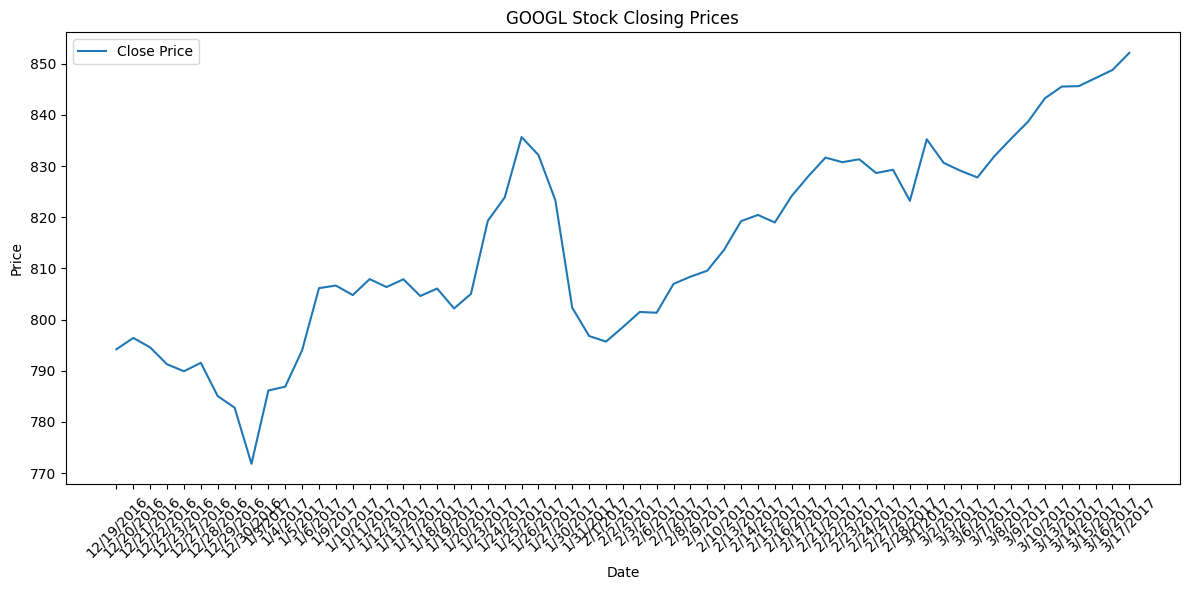

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title("GOOGL Stock Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

<h4><b>Preprocessing - Dates & Scaling</b></h4>

In [10]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data = df['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

<h4><b>Sequence Creation Function</b></h4>

In [11]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(data_scaled, seq_len)

<h4><b>Train - Test Split</b></h4>

In [12]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

<h4><b>Building the Model</b></h4>

In [13]:
model = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(seq_len, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2025-05-03 05:16:45.744089: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


2025-05-03 05:17:15.584570: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


ValueError: math domain error

<h4><b>Evaluation of Model</b></h4>

In [19]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(r2)

-5.150161911507036


In [21]:
from sklearn.metrics import mean_squared_error
rmse = (np.sqrt(mean_squared_error(y_test, y_pred)))
print(rmse)

25.341672228656932
